In [1]:
from rdkit import Chem
import pandas as pd
from rdkit.Chem import PandasTools

from IPython.display import HTML
def show_df(df):
    return HTML(df.to_html(notebook=True))

# Function: implements murcko scaffold algorithm as originally described

In [2]:
from rdkit.Chem.Scaffolds import MurckoScaffold
from rdkit.Chem import rdchem

def GetTrueScaffold(mol,generic=False):
    #Not sure if hybridisation of dummy atom is correct
    #Not sure on properties
    #Seems to work as desired
    """
    Takes RDKit mol object
    Returns mol object of the murcko scaffold with original algorithm
    Stereochemistry is lost
    """
    mol = MurckoScaffold.GetScaffoldForMol(mol)
    atom_to_remove = []
    atom_to_clean = []
    
    for a in mol.GetAtoms():
        #Remove chirality
        mol.GetAtomWithIdx(a.GetIdx()).SetChiralTag(Chem.ChiralType.CHI_UNSPECIFIED)
        
        #For atoms bonded to only one other atom, these must be removed
        if len(a.GetBonds()) == 1:
            #Get index of atom to delete and append to deletion list
            atom_to_remove.append(a.GetIdx())

    #If there are atoms to delte
    if len(atom_to_remove) > 0:
        #Create an editable molecule (now RW)
        emol = rdchem.RWMol(mol)
        #Every time an atom is delted the index changes
        #Deletion list must be reversed to avoid rogue deletions
        for a in atom_to_remove[::-1]:
            #Remove atom by index a
            emol.RemoveAtom(a)
    #If the molecule is already the correct murcko scaffold set emol = mol
    else:
        emol = mol
    
    #This line used to cause errors
    #SanitizeMol(emol) often failed due to aromaticity
    #Attempts to solve this included replacing previously bonded atoms with the
    #wild card *
    #It seems clearing aromatic flags solved the issue
    try:
        #Clearing aromatic flags seems to fix everything
        Chem.Kekulize(emol,clearAromaticFlags=True)
        Chem.SanitizeMol(emol)
    except:
        #Error
        #Will show the input molecule and attempted editted molecule (before sanitization attempt)
        display("Input Mol")
        display(mol)
        display("Output Emol")
        display(emol)
        raise ("Error in santisation of new molecule")
        return False
    
    #The above procedure will remove all remaining decorating groups on scaffold
    #In some cases (like sulfonyl) this will leave an aliphatic chain
    #Additional application of MurckoScaffold algorithm is needed
    #However the RDKit implementation is sufficient 
    emol = MurckoScaffold.GetScaffoldForMol(emol)
    
    #If the generic scaffold is desired (Flag), make generic
    if generic:
        emol = MurckoScaffold.MakeScaffoldGeneric(emol)

    #Return the molecule
    return emol

# Replace atoms present in murcko scaffold with wild card. All side chains remain intact

In [3]:
def CleanScaffold(mol,seed=None):
    """
    input:
        RDKit mol
    param:
        seed: RDKit smarts mol. If provided, only the substructure matching the seed will be
            replaced by wild card, not entire murcko. This might be desired in cases of scaffold hopping. 
    returns:
        RDKit mol with backbone replaced by wildcard atoms
    """
    #Note, orignal implentation replaces backbone with carbon, however this caused issues in cases of hypervalency
    #mol = Chem.MolFromSmiles(Chem.MolToSmiles(mol))
    
    #This does not work
    if not seed:
        seed = GetTrueScaffold(mol)

    for atom_idx in mol.GetSubstructMatch(seed):
        mol.GetAtomWithIdx(atom_idx).SetAtomicNum(0)

        
    return mol

# Function: from a pair of molecules, find the fragments. Optional seed (smarts string) to accelerate substructure search. Flag "clean_scaffold" will replace all murcko scaffold atoms in mol with wildcard, neccessary for succesfull fragment finding 

In [4]:
#This will fail in cases where the seed contains hetero atoms
#and the scaffold has been cleaned
from rdkit.Chem import ReplaceCore

def GetFragmentsFromPair(mol1,mol2,seed="",clean_scaffold=False):
    """
    inputs:
        mol1: RDKit mol
        mol2: RDKit mol
    params:
        seed: RDKit smarts mols
        clean_scaffold: if true, replace all atoms in scaffold with wildcard
        
    returns:
        frags1: RDKit mol object of fragments from mol1
        frags2: RDKit mol object of fragments from mol2
    """
    
    if clean_scaffold:
        mol1 = CleanScaffold(mol1,seed=seed)
        mol2 = CleanScaffold(mol2,seed=seed)

    #Not the best code here, not not sure how to solve mcs issue
    #Ideally would just pass seed=None into the mcs search when a seed is not provided, however
    #This did not work. As such need to run the if statement, howver this is code duplication and
    #No desired
    if seed != "":
        mcs = FindMCS([mol1, mol2],
                         timeout=1,
                         ringMatchesRingOnly=True,
                         completeRingsOnly=True,
                         seedSmarts=Chem.MolToSmarts(seed),
                          #atomCompare=AtomCompare.CompareAnyHeavyAtom,
                          #ringCompare=RingCompare.IgnoreRingFusion,
                          bondCompare=BondCompare.CompareAny,
                        )
    else:
        mcs = FindMCS([mol1, mol2],
                         timeout=1,
                         ringMatchesRingOnly=True,
                         completeRingsOnly=True,
                         #seedSmarts=Chem.MolToSmarts(seed),
                          #atomCompare=AtomCompare.CompareAnyHeavyAtom,
                          #ringCompare=RingCompare.IgnoreRingFusion,
                          bondCompare=BondCompare.CompareAny,
                        )
    
    
    #From found mcs (smarts object), return the RDKit smarts mol
    mcs = Chem.MolFromSmarts(mcs.smartsString)
    
    if not mcs:
        display(mol1,mol2,seed)
    
    #Replace the core of mol1 and mol2 by mcs, hence isolating modified fragments
    frags1 = ReplaceCore(mol1,mcs,labelByIndex=True)
    frags2 = ReplaceCore(mol2,mcs,labelByIndex=True)
    
    #Return two rdkit mol objects containing all fragments
    return frags1,frags2

In [5]:
def GetFragments(mol, seed="", clean_scaffold=False):
    """
    input:
        mol: RDKit mol
    params:
        Seed: RDKit smarts mol
        clean_scaffold: If true, replace atoms in mol backbone with wildcard
            If seed is passed, this will be used for cleaning
            
    returns:
        Sidechain fragments of mol, indexed with respect to 
    """
    
    #Note: issues may arrise if cleaning
    #Cleaning only really needed when considering pairs
    
    if seed == "":
        seed = GetTrueScaffold(mol)

    if clean_scaffold:
        mol = CleanScaffold(mol,seed=seed)
        
    fragments = ReplaceCore(mol,
                            seed,
                            labelByIndex=True
                           )
    return fragments

# Function: from a pair of rdkit mol fragments, find the fragments which are not shared, ie have changed

In [6]:
from rdkit.Chem.rdMolHash import MolHash
from rdkit.Chem.rdMolHash import HashFunction

def UniqueFragments(frags1,frags2,return_single=False):
    """
    input:
        frags1: RDKit mol, core removed leaving only fragments
        frags2: RDKit mol, core removed leaving only fragments
    param:
        return_single: (bool), if true: combines the resulting fragment
        set into one array and returns together. Might be good for scoring
        
    returns:
        unique1: list of RDKit mol fragments present on mol1 but not mol2
        unique2: list of RDKit mol fragments present on mol2 but nor mol1
    """
    frags1=Chem.GetMolFrags(frags1, asMols=True)
    frags2=Chem.GetMolFrags(frags2, asMols=True)
    
    hash1 = [MolHash(x,HashFunction.CanonicalSmiles) for x in frags1]
    hash2 = [MolHash(x,HashFunction.CanonicalSmiles) for x in frags2]
    
    hash1 = set(hash1)
    hash2 = set(hash2)
    
    unique1 = hash1-hash2
    unique2 = hash2-hash1
    
    if return_single:
        return list(unique1.union(unique2))
    else:
        return list(unique1), list(unique2)

# Function: get seed

In [7]:
from rdkit.Chem.rdFMCS import FindMCS
from rdkit.Chem.rdFMCS import AtomCompare
from rdkit.Chem.rdFMCS import RingCompare
from rdkit.Chem.rdFMCS import BondCompare

def GetSeed(mols, clean_scaffold=False):
    """
    input: array of RDKit mols
    param: clean_scaffold (bool), if true: replace all
        atoms in murcko scaffold with wildcard (cleaning needed when scaffold
        atoms transform as this breaks RBFENN). If true, all subsequent comparsions need
        scaffold cleaning. 
        
    returns: RDkit smarts mols of seed for entire dataset
    """
    if clean_scaffold:
        new_mols = []
        for mol in mols:
            try:
                #This might be modifying molecule in place
                #find way to avoid this
                mol = CleanScaffold(mol)
                new_mols.append(mol)
            except:
                print("Error in cleaning molecule:")
                print("This molecule will be ignored in seed finding")
                display(mol)
                #raise ValueError("Error: mol could not be cleaned. Likely contains hypervalent atoms")
        mols = new_mols
    
    seed = FindMCS(mols, 
            atomCompare=AtomCompare.CompareAny,
            ringCompare=RingCompare.IgnoreRingFusion,
            bondCompare=BondCompare.CompareAny,
            #completeRingsOnly=True
            #threshold=0.8,#Much slower
           )
    
    return Chem.MolFromSmarts(seed.smartsString)

# Get Fragments

In [8]:
moonshot_file = "../../covid_submissions_all_info.csv"
df = pd.read_csv(moonshot_file)
PandasTools.AddMoleculeColumnToFrame(df,'SMILES','Molecule')

/home/nichrun/miniconda3/envs/data_driven_fep_rel/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (3,6,7,9,10,11,12,13,14,15,18,19,27,28,29,30,31,32,33,34,35,36,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,66,67,69,70,71,72,73,74,75,76,84,85,86,87,89,90,91,92,93,94,95,96,104,105,106,107,109,110,111,112,113,114,115,116,124,125,126,127,129,130,131,132,133,134,135,136,144,145,146,147,149,150,151,152,153,154,155,156,164,165,166,167,169,170,171,172,173,174,175,176,184,185,186,187,189,190,191,192,193,194,195,196,204,205,206,207,209,210,211,212,213,214,215,216,224,225,226,227,229,230,231,232,233,234,235,236,244,245,246,247,249,253,254,255,256,257,258,259,275,276) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
[19:34:03] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [19:34:03] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [19:34

In [9]:
mol_cluster = []
with open("largest_generic_scaffold.csv","r") as readfile:
    for line in readfile.readlines():
        mol_cluster.append(line.strip())

In [10]:
mols = df.loc[df["CID"].isin(mol_cluster)]
mols = mols[["CID", "Molecule"]]

In [11]:
all_mols_subset = [Chem.MolFromSmiles(Chem.MolToSmiles(x)) for x in list(mols["Molecule"])]

In [12]:
seed = GetSeed(all_mols_subset, clean_scaffold=True)

In [13]:
mols_subset = [CleanScaffold(Chem.MolFromSmiles(Chem.MolToSmiles(x))) for x in list(mols["Molecule"])[:10]]

In [14]:
mols_subset = [CleanScaffold(Chem.MolFromSmiles(Chem.MolToSmiles(x)), seed=seed) for x in list(mols["Molecule"])[:10]]

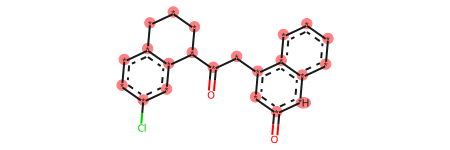

In [15]:
mols_subset[0]

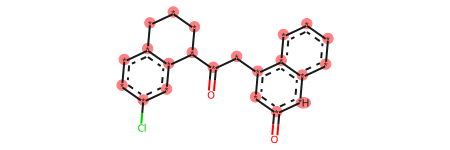

In [16]:
CleanScaffold(mols_subset[0],seed=seed)

In [17]:
#CleanScaffold(mols_subset[1],seed=seed)

In [18]:
"""
Precleaning without seed works
why?
"""

'\nPrecleaning without seed works\nwhy?\n'

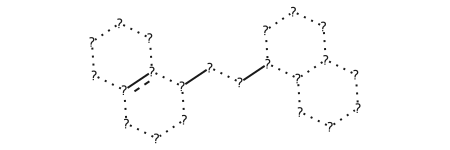

In [19]:
seed

In [20]:
all_frags = []
pairwise = []
m_array = []

for i in range(len(mols_subset)):
    for j in range(i):
        frags1, frags2 = GetFragmentsFromPair(mols_subset[i],mols_subset[j],clean_scaffold=True)#Must run without seed and clean scaffold = True
        m_array.append((all_mols_subset[i],all_mols_subset[j]))
        all_frags.append((frags1,frags2))

In [21]:
from rdkit.Chem import Draw

In [22]:
display_mols = []
for (m1,m2),(f1,f2) in zip(m_array,all_frags):
    
    if Chem.MolToSmiles(f1) == "":
        f1 = Chem.MolFromSmiles("C")
    if Chem.MolToSmiles(f2) == "":
        f2 = Chem.MolFromSmiles("C")
    
    display_mols += [m1,m2,f1,f2]

/home/nichrun/miniconda3/envs/data_driven_fep_rel/lib/python3.7/site-packages/rdkit/Chem/Draw/IPythonConsole.py:192: UserWarning: Truncating the list of molecules to be displayed to 100. Change the maxMols value to display more.
  % (maxMols))


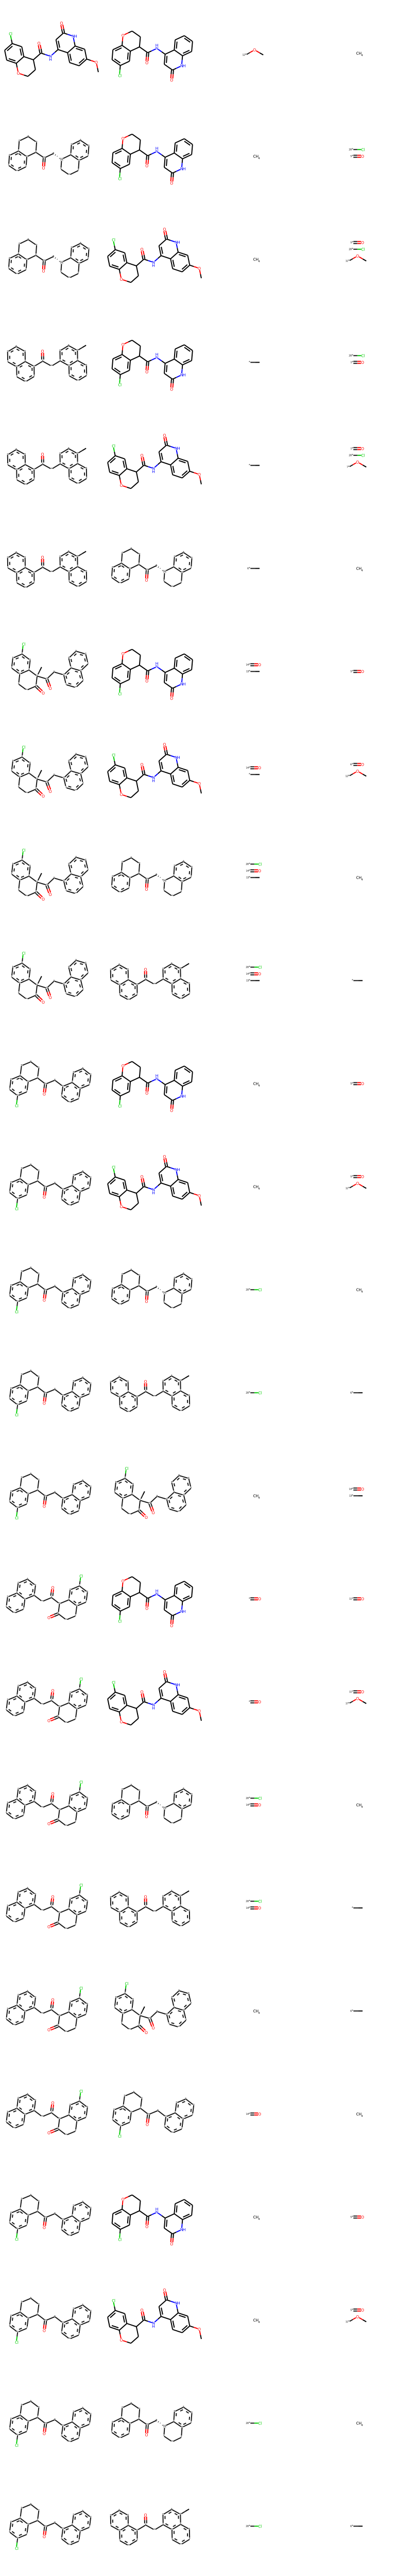

In [23]:
display(Draw.MolsToGridImage(display_mols,molsPerRow=4,maxMols=100))